## Natural Computing - Genetic Algorithm with PyGAD
This notebook is used on Kaggle for the Natural Computing project.
In this notebook the dataset Metastatic Tissue Classification - PatchCamelyon (`metastatic-tissue-classification-patchcamelyon`) is used.

First install pygad for later use, since this isn't included in the default Kaggle workspace.

In [1]:
!pip install pygad

     |████████████████████████████████| 46 kB 453 kB/s 


In [2]:
import tensorflow.keras
import pygad.kerasga
import numpy as np
import pandas as pd
import pygad
import cv2
import h5py

from keras.datasets import mnist
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from sklearn.metrics import confusion_matrix

#### Data
Import the data from the dataset and define the number of samples from the train set to run with the Genetic Algorithm.

In [3]:
num_samples = 200

x_train = []
y_train = []

x_test = []
y_test = []

with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/training_split.h5', 'r') as f:
    x_train = np.array(f['x'][:num_samples])
    
with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_train_y.h5', 'r') as f:
    y_train = np.array(f['y'][:num_samples].flat)
    
with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/pcam/test_split.h5', 'r') as f:
    x_test = np.array(f['x'][:])
    
with h5py.File('/kaggle/input/metastatic-tissue-classification-patchcamelyon/Labels/Labels/camelyonpatch_level_2_split_test_y.h5', 'r') as f:
    y_test = np.array(f['y'][:].flat)

In [4]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(200, 96, 96, 3) (200,)
(32768, 96, 96, 3) (32768,)


In [5]:
input_img = (96, 96, 3) #All images in PatchCamelyon are in this shape, use for the input_shape of the Keras model

Setup of the Keras model VGG16

In [6]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_img)

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = Flatten()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=x)
print(model.summary())

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [7]:
keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=10)

#### Fitness function
Define the fitness function:
- Form the model weights for usage in the VGG16 model
- Apply the model weights
- Predict the train set with updated model
- Calculate Binary Crossentropy
- Define fitness score
- Return fitness score for particular solution

In [8]:
def fitness_func(solution, sol_idx):
    global x_train, y_train, keras_ga, model
    
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)

    model.set_weights(model_weights_matrix)
    
    predictions = model.predict(x_train)
    
    bce = tensorflow.keras.losses.BinaryCrossentropy()
    solution_fitness = 1.0 / (bce(y_train, predictions).numpy() + 0.00000001)
    
    return solution_fitness

The callback generation is a way to displays information per generation. In this case we use this to display the generation number and the fitness score of the current best solution.

In [9]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

We form a categorical array from the y labels of train and test to make it easier to work with the Binary Cross Entropy.

In [10]:
y_train = tensorflow.keras.utils.to_categorical(y_train)
print(len(x_train),y_train.shape)

y_test = tensorflow.keras.utils.to_categorical(y_test)
print(len(x_test),y_test.shape)

200 (200, 2)
32768 (32768, 2)


In [11]:
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = keras_ga.population_weights # Initial population of network weights.
parent_selection_type = "sss" # Type of parent selection.
crossover_type = "single_point" # Type of the crossover operator.
mutation_type = "random" # Type of the mutation operator.
mutation_percent_genes = 10 # Percentage of genes to mutate.
keep_parents = 2 # Number of parents to keep in the next population.

#### PyGAD instance
Below the PyGAD Genetic Algorithm gets instantiated with the parameters set up above. After that it will run it's generations and show the Iteration vs. Fitness result graph.

Generation = 1
Fitness    = 0.16891268519306474
Generation = 2
Fitness    = 0.17815756263659902
Generation = 3
Fitness    = 0.17815756263659902
Generation = 4
Fitness    = 0.17815756263659902
Generation = 5
Fitness    = 0.17815756263659902
Generation = 6
Fitness    = 0.17831737872048262
Generation = 7
Fitness    = 0.18137508816822093
Generation = 8
Fitness    = 0.1920173625294338
Generation = 9
Fitness    = 0.20138468060290965
Generation = 10
Fitness    = 0.2150468783075817
Generation = 11
Fitness    = 0.2150468783075817
Generation = 12
Fitness    = 0.21674136954439183
Generation = 13
Fitness    = 0.21819424991347616
Generation = 14
Fitness    = 0.23468936297235168
Generation = 15
Fitness    = 0.23468936297235168
Generation = 16
Fitness    = 0.23468936297235168
Generation = 17
Fitness    = 0.23468936297235168
Generation = 18
Fitness    = 0.2453497477836056
Generation = 19
Fitness    = 0.2453497477836056
Generation = 20
Fitness    = 0.24786584241412066
Generation = 21
Fitness    = 0.251

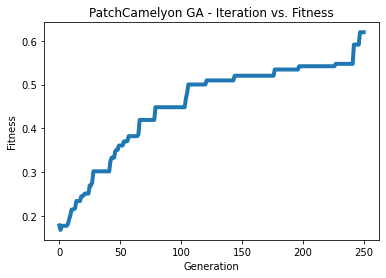

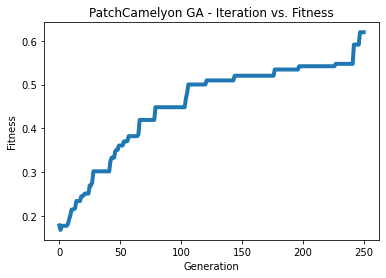

In [12]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

ga_instance.plot_result(title="PatchCamelyon GA - Iteration vs. Fitness", linewidth=4)

Plotting the final best solution after all of the generations have been done.

In [13]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))


Fitness value of the best solution = 0.619269913019987
Index of the best solution : 0


Now we will apply the best solution to our model. After that we will run the final predictions for both the test set as for the train set. Also with Binary Cross Entropy and Binary Accuracy.

In [14]:
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)

In [15]:
model.set_weights(best_solution_weights)
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_test)

In [16]:
bce = tensorflow.keras.losses.BinaryCrossentropy()
print("Binary Crossentropy : ", bce(y_train, predictions_train).numpy())

ba = tensorflow.keras.metrics.BinaryAccuracy()
ba.update_state(y_train, predictions_train)
accuracy = ba.result().numpy()
print("Accuracy : ", accuracy)

y_train_argmax = np.argmax(y_train, axis=1)
predictions_train = np.argmax(predictions_train, axis=1)
print(confusion_matrix(y_train_argmax, predictions_train))

Binary Crossentropy :  1.6148047
Accuracy :  0.895
[[ 77  11]
 [ 10 102]]


In [17]:
bce = tensorflow.keras.losses.BinaryCrossentropy()
print("Binary Crossentropy : ", bce(y_test, predictions_test).numpy())

ba = tensorflow.keras.metrics.BinaryAccuracy()
ba.update_state(y_test, predictions_test)
accuracy = ba.result().numpy()
print("Accuracy : ", accuracy)

y_test_argmax = np.argmax(y_test, axis=1)
predictions_test = np.argmax(predictions_test, axis=1)
print(confusion_matrix(y_test_argmax, predictions_test))

Binary Crossentropy :  4.351452
Accuracy :  0.7157898
[[12359  4032]
 [ 5281 11096]]
